In [1]:
import os
from tqdm import tqdm

def load_image_paths(directory):
  """Carrega os caminhos das imagens dentro de um diretório com uma barra de progresso.

  Args:
    directory: O caminho para o diretório que contém as imagens.

  Returns:
    Uma lista de caminhos para os arquivos de imagem.
  """
  image_paths = []
  filenames = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
  for filename in tqdm(filenames, desc=f"Carregando caminhos de {directory}", leave=True):
    filepath = os.path.join(directory, filename)
    image_paths.append(filepath)
  return image_paths

# Carrega os caminhos das imagens de ambas as pastas
pristineSS_paths = load_image_paths("C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\pristineSS")
pristineSR_paths = load_image_paths("C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\pristineSR")

# Imprime o número de caminhos carregados de cada pasta
print(f"Carregados {len(pristineSS_paths)} caminhos de 'pristineSS'")
print(f"Carregados {len(pristineSR_paths)} caminhos de 'pristineSR'")

Carregando caminhos de C:\Users\stefa\OneDrive\Documentos\NATALI TCC\pristineSS: 100%|█| 15426/15426 [00:00<00:00, 4454
Carregando caminhos de C:\Users\stefa\OneDrive\Documentos\NATALI TCC\pristineSR: 100%|█| 6000/6000 [00:00<00:00, 334265

Carregados 15426 caminhos de 'pristineSS'
Carregados 6000 caminhos de 'pristineSR'


In [2]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Definir os caminhos dos arquivos
file_x_simsim = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\Zenodo data\\SimSim_SOURCE_X_Illustris2_pristine.npy"
file_y_simsim = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\Zenodo data\\SimSim_SOURCE_y_Illustris2_pristine.npy"
file_x_simreal = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\Zenodo data\\SimReal_SOURCE_X_Illustris0.npy"
file_y_simreal = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\Zenodo data\\SimReal_SOURCE_y_Illustris0.npy"

# Carregar os arquivos usando np.load
X_simsim = np.load(file_x_simsim)
Y_simsim = np.load(file_y_simsim)
X_simreal = np.load(file_x_simreal)
Y_simreal = np.load(file_y_simreal)

In [3]:
# Mostrar informações sobre os dados
print("SimSim:")
print(f"X_simsim.shape: {X_simsim.shape}")
print(f"Y_simsim.shape: {Y_simsim.shape}")
print(f"Y_simsim[0]: {Y_simsim[0]}")

print("\nSimReal:")
print(f"X_simreal.shape: {X_simreal.shape}")
print(f"Y_simreal.shape: {Y_simreal.shape}")

SimSim:
X_simsim.shape: (15426, 3, 75, 75)
Y_simsim.shape: (15426,)
Y_simsim[0]: 1.0

SimReal:
X_simreal.shape: (6000, 3, 75, 75)
Y_simreal.shape: (6000,)


In [4]:
# Combinar os datasets em X e Y com barra de progresso
print("Combinando datasets")
X = np.concatenate((X_simsim, X_simreal), axis=0)
Y = np.concatenate((Y_simsim, Y_simreal), axis=0)
print("Embaralhamento dos dados")
X, Y = shuffle(X, Y, random_state=42)

Combinando datasets
Embaralhamento dos dados


In [5]:
# Divide os dados em conjuntos de treinamento, validação e teste (ex: 70% treino, 10% validação, 20% teste)
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=2/3, random_state=42)

In [6]:
# Normalizando e Transpondo
X_train = X_train.transpose((0, 2, 3, 1))
X_val = X_val.transpose((0, 2, 3, 1))
X_test = X_test.transpose((0, 2, 3, 1))

X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:
# Impressão das dimensões
print("Data dimensions: ")
print("Training set: ", np.shape(X_train), np.shape(Y_train))
print("Validation set: ", np.shape(X_val), np.shape(Y_val))
print("Test Set: ", np.shape(X_test), np.shape(Y_test))

Data dimensions: 
Training set:  (14998, 75, 75, 3) (14998,)
Validation set:  (2142, 75, 75, 3) (2142,)
Test Set:  (4286, 75, 75, 3) (4286,)


In [8]:
# Verificação se todos os dados foram preservados
assert len(X) == len(X_train) + len(X_val) + len(X_test), "Erro: Dados de X não foram preservados!"
assert len(Y) == len(Y_train) + len(Y_val) + len(Y_test), "Erro: Dados de Y não foram preservados!"

In [9]:
# Salvando os dados pré-processados
np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)
np.save("X_val.npy", X_val)
np.save("Y_val.npy", Y_val)
np.save("X_test.npy", X_test)
np.save("Y_test.npy", Y_test)

print("Dados pré-processados salvos!")

Dados pré-processados salvos!


Arquitetura do sistema

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import json

# 1. Carregue os dados
X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy")
X_val = np.load("X_val.npy")
Y_val = np.load("Y_val.npy")
X_test = np.load("X_test.npy")
Y_test = np.load("Y_test.npy")

# Imprima os formatos
print("Formato de X_train:", np.shape(X_train))
print("Formato de Y_train:", np.shape(Y_train))
print("Formato de X_val:", np.shape(X_val))
print("Formato de Y_val:", np.shape(Y_val))
print("Formato de X_test:", np.shape(X_test))
print("Formato de Y_test:", np.shape(Y_test))

Formato de X_train: (14998, 75, 75, 3)
Formato de Y_train: (14998,)
Formato de X_val: (2142, 75, 75, 3)
Formato de Y_val: (2142,)
Formato de X_test: (4286, 75, 75, 3)
Formato de Y_test: (4286,)


In [11]:
# 2. Defina a forma dos dados de entrada
input_shape = np.shape(X_train)[1:] 

In [12]:
# 3. Defina a arquitetura do modelo
inputs = Input(shape=input_shape)
# Camadas convolucionais
x = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_last')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.5)(x)

x = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.5)(x)

x = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_last')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.5)(x)

# Camadas densas
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)

# Camada de saída
outputs = Dense(1, activation='sigmoid')(x)  

In [13]:
# 4. Define o modelo
model = Model(inputs=inputs, outputs=outputs)

In [14]:
# 5. Define parâmetros de compilação
optimizer = 'adam'
metrics = ['accuracy']
loss = 'binary_crossentropy'

In [15]:
# 6. Compila o modelo
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 75, 75, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 75, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 38, 38, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 38, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 38, 38, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 38, 38, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 19, 19, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 19, 19, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,617 (834.44 KB)

 Trainable params: 213,505 (834.00 KB)

 Non-trainable params: 112 (448.00 B)

In [16]:
# 7. Define o caminho para salvar o checkpoint
checkpoint_filepath = 'melhor_modelo_pesos.keras'

In [20]:
# 8. Define os callbacks
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor='val_acc', # Certifique-se que 'monitor' está correto
    mode='max', 
    verbose=1, 
    save_best_only=True
)

In [21]:
# 9. Define parâmetros de treinamento
batch_size = 32
nb_epoch = 5
shuffle = True

# 10. Treina o modelo
history = model.fit(
    x=X_train, 
    y=Y_train, 
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    shuffle=shuffle,
    verbose=True,
    callbacks=callbacks
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.6517 - loss: 0.6394 - val_accuracy: 0.5686 - val_loss: 0.8097
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.6587 - loss: 0.6341 - val_accuracy: 0.6317 - val_loss: 0.6895
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.6528 - loss: 0.6296 - val_accuracy: 0.5233 - val_loss: 0.7280
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.6685 - loss: 0.6177 - val_accuracy: 0.4608 - val_loss: 0.7519
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.6839 - loss: 0.6091 - val_accuracy: 0.6008 - val_loss: 0.6836


In [22]:
# Imprime o histórico
print(history.history)

{'accuracy': [0.6478196978569031, 0.6620882749557495, 0.6643552184104919, 0.6680223941802979, 0.687624990940094], 'loss': [0.6413450837135315, 0.6318570375442505, 0.6235508322715759, 0.6219193935394287, 0.6073490381240845], 'val_accuracy': [0.5686274766921997, 0.6316526532173157, 0.5233426690101624, 0.46078431606292725, 0.6008403301239014], 'val_loss': [0.8096542954444885, 0.6894900798797607, 0.7279872298240662, 0.7519070506095886, 0.6836338043212891]}


In [23]:
# Salva o modelo completo no formato .keras
model.save("meu_modelo.keras")

In [24]:
# Salva a arquitetura do modelo em JSON
model_json = model.to_json()
with open("modelo_arquitetura.json", "w") as json_file:
    json_file.write(model_json)

In [25]:
# Salva o histórico de treinamento
f_history = "history.json"
with open(f_history, 'w') as f:
    json.dump(history.history, f, indent=4)

In [26]:
# Carrega o modelo salvo
loaded_model = load_model("meu_modelo.keras")

In [27]:
# Validação dos dados do modelo:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6216 - loss: 0.6707
compile_metrics: 61.55%


Graficação do histórico de perca pela acurácia

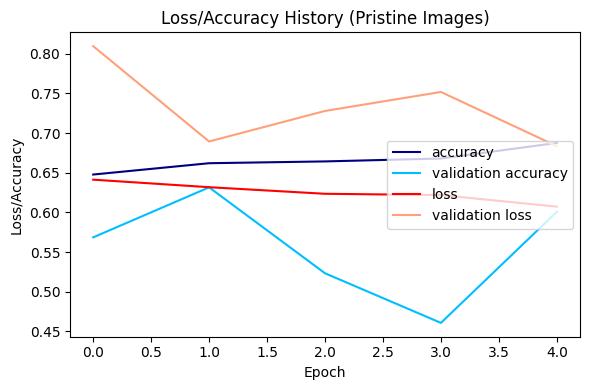

In [29]:
import matplotlib.pyplot as plt
import json

# Carrega o histórico de treinamento
with open("history.json", "r") as f:
    history = json.load(f)

# Extrai os valores do histórico
loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']
# Cria o gráfico
epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

# Plota as curvas de perda e acurácia
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")

# Ajusta o layout e adiciona legendas
plots = plot1_loss + plot1_val_loss + plot1_lacc + plot1_val_lacc
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='center right')

# Exibe o gráfico
plt.show()

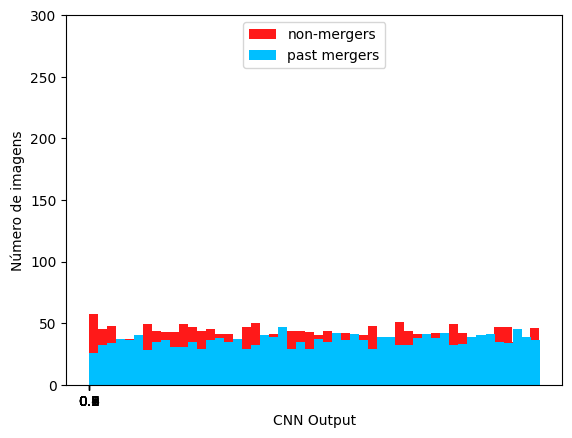

In [149]:
#ADAPTAR
# Plote do histograma
bins = 50
plt.hist(non, bins, alpha=0.9, label='non-mergers', color='red')
plt.hist(past, bins, alpha=1, label='past mergers', color='deepskyblue')
# plt.hist(future, bins, alpha=1, label='future mergers', color='navy')  # Remova esta linha se você não precisa de 'future'
plt.legend(loc='upper center')

# Ajuste do eixo x
plt.xticks(np.arange(0.1, 1, step=0.1))  # Intervalo de 0.1

# Ajuste do eixo y
max_y = max(len(non), len(past)) + 10  # Ajuste o limite superior
plt.yticks(np.arange(0, max_y + 10, step=50))  # Intervalo de 50

# Ajusta a visualização do eixo y para 0 50 100 150 ... 300
plt.ylim(0, 300)  # Define o limite superior do eixo y como 300

plt.xlabel("CNN Output")
plt.ylabel("Número de imagens")
plt.show()

Validação do grupo de TESTE

In [33]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # Importa LogNorm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, roc_curve, roc_auc_score  # Importa as funções

# predict
prob = loaded_model.predict(X_test)
pred = (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = confusion_matrix(Y_test, pred, labels=labels)  # Use 'confusion_matrix' diretamente
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

fpr, tpr, thresholds = roc_curve(Y_test, prob, pos_label=1)  # Use 'roc_curve' diretamente
auc = roc_auc_score(Y_test, prob)  # Use 'roc_auc_score' diretamente
print("AUC:", auc)

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
cm [[1660.  460.]
 [1750.  416.]]
cm_norm [[0.78301887 0.21698113]
 [0.8079409  0.1920591 ]]
AUC: 0.58799325772226


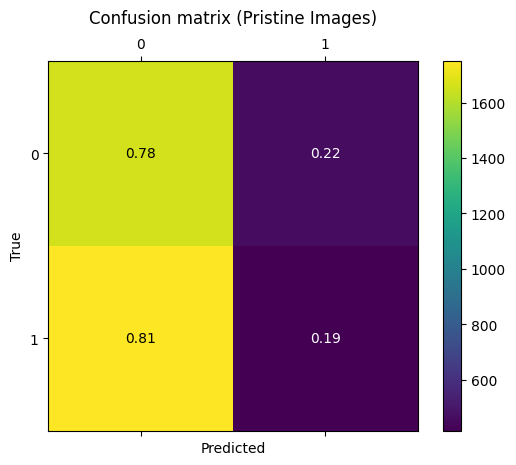

In [36]:
#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix (Pristine Images)', y=1.08)
fig.colorbar(cax)

# Define a posição dos ticks
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

# Define os rótulos dos ticks
ax.set_xticklabels(labels)  
ax.set_yticklabels(labels)

plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
plt.show()

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
AUC: 0.58799325772226


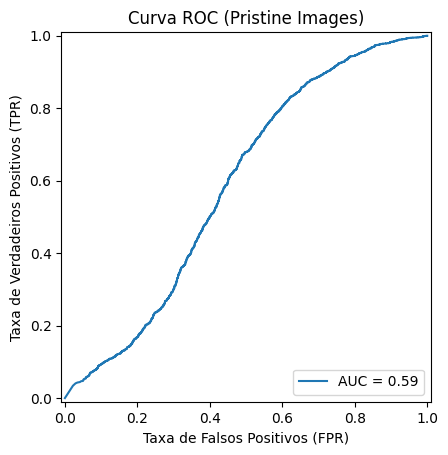

In [39]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Preveja as probabilidades para o conjunto de teste
probabilidades_previstas = loaded_model.predict(X_test)  # Defina a variável

# Curva ROC e AUC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, probabilidades_previstas, pos_label=1)
auc = metrics.roc_auc_score(Y_test, probabilidades_previstas)
print("AUC:", auc)

# Plotando a curva ROC usando RocCurveDisplay
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
disp.plot()
plt.title('Curva ROC (Pristine Images)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.show()

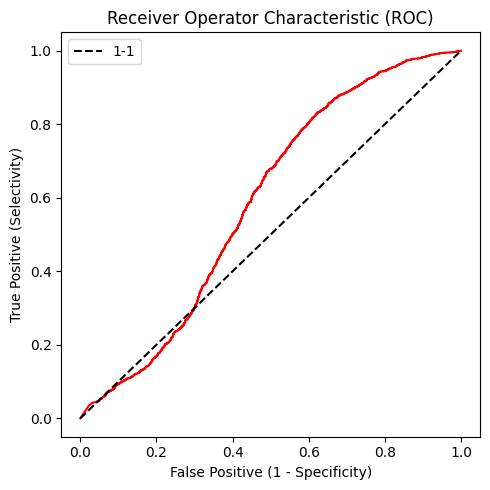

In [40]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()

In [43]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Preveja as probabilidades para o conjunto de teste
probabilidades_previstas = loaded_model.predict(X_test) 

# Faça previsões de classe (0 ou 1) usando um limiar de 0.5
previsoes = (probabilidades_previstas > 0.5).astype('int32') 

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, previsoes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, previsoes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, previsoes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, previsoes)
print('F1 score: %f' % f1)

# brier score
bs = brier_score_loss(Y_test, probabilidades_previstas)
print('Brier score: %f' % bs)

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy: 0.484368
Precision: 0.474886
Recall: 0.192059
F1 score: 0.273504
Brier score: 0.502597


Exemplos de Imagens

In [44]:
from tqdm import tqdm

# Procurando por exemplos
for i in tqdm(range(len(Y_test)), desc="Procurando por exemplos"):
    if Y_test[i] == 1 and previsoes[i] == 1:  # TP (Verdadeiro Positivo)
        pass  # Não faça nada se for TP
    elif Y_test[i] == 0 and previsoes[i] == 1:  # FP (Falso Positivo)
        pass  # Não faça nada se for FP
    elif Y_test[i] == 0 and previsoes[i] == 0:  # TN (Verdadeiro Negativo)
        pass  # Não faça nada se for TN
    elif Y_test[i] == 1 and previsoes[i] == 0:  # FN (Falso Negativo)
        pass  # Não faça nada se for FN

Procurando por exemplos: 100%|██████████████████████████████████████████████████| 4286/4286 [00:00<00:00, 96774.26it/s]


In [45]:
# Contar quantos valores reais coincidem com as previsões
n_acertos = sum(Y_test == previsoes)
print(f"Número de acertos: {n_acertos}")

# Imprimir os índices das previsões corretas (sem imprimir os índices)
indice_previsao = 1
for i in range(len(Y_test)):
    if Y_test[i] == previsoes[i]:
        #print(f"Previsão correta {indice_previsao}: Índice {i}")
        indice_previsao += 1

print(f"Total de previsões corretas: {indice_previsao - 1}") 

Número de acertos: [3410  876 3410 ...  876  876  876]
Total de previsões corretas: 2076


In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Imprime as probabilidades de saída para os exemplos escolhidos
print(f"Exemplo TP (84): {probabilidades_previstas[84]}")
print(f"Exemplo TP (1370): {probabilidades_previstas[1370]}")
print(f"Exemplo TP (2031): {probabilidades_previstas[2031]}")
print(f"Exemplo TP (3003): {probabilidades_previstas[3003]}")

print(f"Exemplo FP (560): {probabilidades_previstas[560]}")
print(f"Exemplo FP (1228): {probabilidades_previstas[1228]}")
print(f"Exemplo FP (2878): {probabilidades_previstas[2878]}")
print(f"Exemplo FP (3026): {probabilidades_previstas[3026]}")

print(f"Exemplo TN (564): {probabilidades_previstas[564]}")
print(f"Exemplo TN (1056): {probabilidades_previstas[1056]}")
print(f"Exemplo TN (2083): {probabilidades_previstas[2083]}")
print(f"Exemplo TN (3063): {probabilidades_previstas[3063]}")

print(f"Exemplo FN (465): {probabilidades_previstas[465]}")
print(f"Exemplo FN (1546): {probabilidades_previstas[1546]}")
print(f"Exemplo FN (2241): {probabilidades_previstas[2241]}")
print(f"Exemplo FN (3037): {probabilidades_previstas[3037]}")

Exemplo TP (84): [0.9956367]
Exemplo TP (1370): [0.00863225]
Exemplo TP (2031): [8.220441e-05]
Exemplo TP (3003): [4.5881236e-05]
Exemplo FP (560): [0.9774566]
Exemplo FP (1228): [2.8582603e-05]
Exemplo FP (2878): [0.995267]
Exemplo FP (3026): [1.]
Exemplo TN (564): [3.6347137e-05]
Exemplo TN (1056): [8.805008e-05]
Exemplo TN (2083): [2.7396187e-05]
Exemplo TN (3063): [5.6551195e-05]
Exemplo FN (465): [3.0085017e-05]
Exemplo FN (1546): [0.31950235]
Exemplo FN (2241): [3.199807e-05]
Exemplo FN (3037): [5.925085e-05]


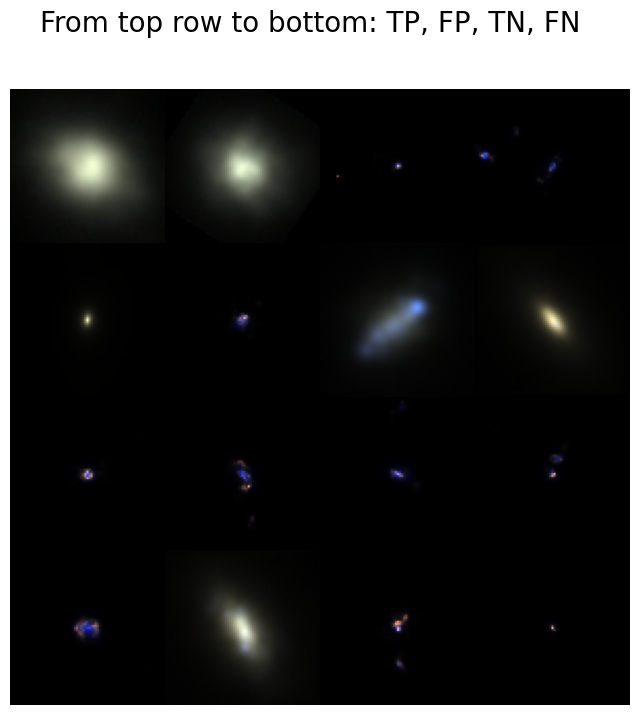

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# plot examples
tp1 = X_test[84]  # Acesse a imagem inteira
tp2 = X_test[1370]
tp3 = X_test[2031]
tp4 = X_test[3003]

fp1 = X_test[560]
fp2 = X_test[1228]
fp3 = X_test[2878]
fp4 = X_test[3026]

tn1 = X_test[564]
tn2 = X_test[1056]
tn3 = X_test[2083]
tn4 = X_test[3063]

fn1 = X_test[465]
fn2 = X_test[1546]
fn3 = X_test[2241]
fn4 = X_test[3037]

examples = [tp1, tp2, tp3, tp4, fp1, fp2, fp3, fp4, tn1, tn2, tn3, tn4, fn1, fn2, fn3, fn4]

def normalize_image(image):
  """Normaliza uma imagem para o intervalo [0, 1]."""
  min_val = np.min(image)
  max_val = np.max(image)
  return (image - min_val) / (max_val - min_val)


fig1 = plt.figure(figsize=(8, 8))

for i, image in enumerate(examples):
    fig1.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=20)
    plt.subplot(4, 4, i + 1)
    plt.axis("off")

    # Verifique o tamanho da imagem
    #print(f"Tamanho da imagem {i+1}: {image.shape}")

    # Se a imagem tiver 3 canais, combine-os em um único canal usando a média
    if image.shape[1] == 3:
        # Calcula a média dos canais para criar um único canal
        image = np.mean(image, axis=1, keepdims=True)  # Mantém a dimensão do canal
        image = image.reshape((75, 75))
    else:
        # Se a imagem já tiver 75x75, apenas redimensione-a
        #image = image.reshape((75, 75))  # Remova o reshape redundante

       # Plota a imagem normalizada localmente com o gradiente de cores e contraste ajustado
        plt.imshow(normalize_image(image), aspect='auto', cmap='gray', vmin=0, vmax=1.2) # Aumente o vmax para mais luminosidade

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

Samples de merges passadas e futuras

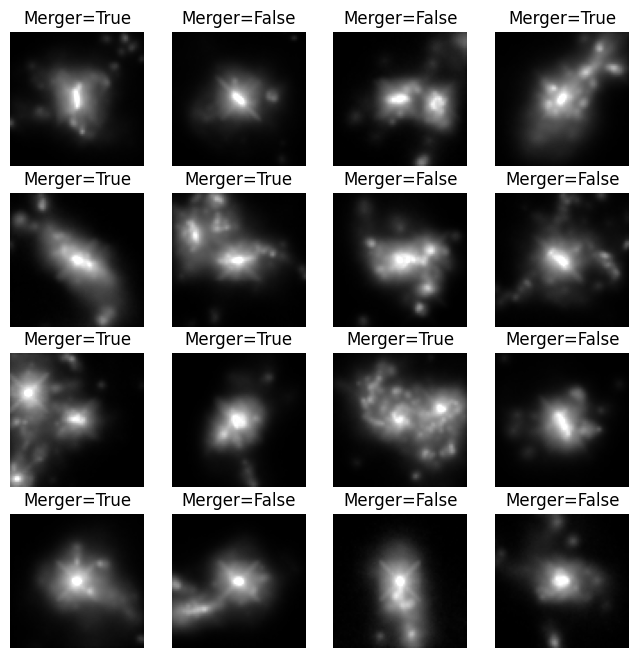

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm

# Caminho do arquivo FITS
file_fits = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"

# Abrir o arquivo FITS
hdulist = fits.open(file_fits)

# Acessar o cabeçalho do primeiro HDU (hdu[0])
header = hdulist[0].header

# Definir a seed para garantir a mesma seleção de imagens
#np.random.seed(206265)  # descomente para obter sempre a mesma seleção

# Selecionar 16 imagens aleatórias
example_ids = np.random.choice(hdulist[1].data.shape[0], 16)

# Pegar as imagens F160W (índice=1) do conjunto de dados simulado para as seleções
examples = [hdulist[0].data[j, 1, :, :] for j in example_ids]

# Inicializar a figura
fig = plt.figure(figsize=(8, 8))

# Loop pelas imagens selecionadas aleatoriamente e plotar com rótulos
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i + 1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    ax.set_title('Merger='+str(bool(hdulist[1].data[example_ids[i]][0])))

    ax.axis('off')

plt.show()

hdulist.close()

In [87]:
import json
import pandas as pd

# Caminho do arquivo JSON
merger_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\mergerTF.json"

# Carrega o arquivo JSON
with open(merger_file, 'r') as f:
    merger_data = json.load(f)

# Extrai os valores da coluna 'merger'
merger_list = [item['merger'] for item in merger_data]

# Converte as strings 'True' e 'False' para booleanos e depois para inteiros
merger_list_boolean = [1 if item == 'True' else 0 for item in merger_list]

# Cria um DataFrame com os valores booleanos convertidos para inteiros
merger_df = pd.DataFrame({'merger': merger_list_boolean})

# Salva o DataFrame com valores booleanos convertidos para inteiros em um novo arquivo JSON
merger_df.to_json('mergerTF_boolean.json', orient='records')

# Imprime o DataFrame (opcional)
print(merger_df)

      merger
0          0
1          1
2          1
3          1
4          1
...      ...
8926       0
8927       0
8928       0
8929       0
8930       0

[8931 rows x 1 columns]


In [91]:
import json

# Caminho para o arquivo de entrada
merge_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\illustris_morphs_rf_snap68_merge.json"

# Abre o arquivo JSON para leitura
with open(merge_file, 'r') as f:
    data = json.load(f)

# Converte todos os elementos da lista para 1
for i in range(len(data)):
    data[i] = 1

# Salva o arquivo JSON com os dados convertidos
with open("illustris_morphs_rf_snap68_merge_boolean.json", 'w') as f:
    json.dump(data, f)

print("Arquivo convertido com sucesso para 'illustris_morphs_rf_snap68_merge_boolean.json'.")

Arquivo convertido com sucesso para 'illustris_morphs_rf_snap68_merge_boolean.json'.


In [92]:
import json

# Caminho para o arquivo de entrada
nonmerge_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\illustris_morphs_rf_snap68_nonmerge.json"

# Abre o arquivo JSON para leitura
with open(nonmerge_file, 'r') as f:
    data = json.load(f)

# Converte todos os elementos da lista para 1
for i in range(len(data)):
    data[i] = 0

# Salva o arquivo JSON com os dados convertidos
with open("illustris_morphs_rf_snap68_nonmerge_boolean.json", 'w') as f:
    json.dump(data, f)

print("Arquivo convertido com sucesso para 'illustris_morphs_rf_snap68_nonmerge_boolean.json'.")

Arquivo convertido com sucesso para 'illustris_morphs_rf_snap68_nonmerge_boolean.json'.


In [98]:
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
import pandas as pd

# Caminho dos arquivos JSON
merge_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\illustris_morphs_rf_snap68_merge_boolean.json"
nonmerge_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\illustris_morphs_rf_snap68_nonmerge_boolean.json"
merger_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\mergerTF_boolean.json"
filter_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-labels-y.npy"

# Carrega os arquivos JSON
with open(merge_file, 'r') as f:
    merge_list = json.load(f)

with open(nonmerge_file, 'r') as f:
    nonmerge_list = json.load(f)

with open(merger_file, 'r') as f:
    merger_list = json.load(f)  

# Carrega o arquivo filter (npy)
filter_list = np.load(filter_file)

# Checa se as listas estão vazias
if not merge_list:
    print("A lista de merge está vazia.")
if not nonmerge_list:
    print("A lista de nonmerge está vazia.")
if not merger_list:
    print("A lista de merger está vazia.")
if filter_list.size == 0:  # Verifica se o array filter_list está vazio
    print("A lista de filter está vazia.")

# Imprime o comprimento de cada lista
print(f"Comprimento da lista de merge: {len(merge_list)}")
print(f"Comprimento da lista de nonmerge: {len(nonmerge_list)}")
print(f"Comprimento da lista de merger: {len(merger_list)}")
print(f"Comprimento da lista de filter: {len(filter_list)}")

# Função para classificar as imagens
def classificar_imagens(merger_list, merge_list, nonmerge_list, filter_list):
    merge_true = []  # TP (Verdadeiro Positivo)
    nonmerge_true = []  # TN (Verdadeiro Negativo)
    nonfuturemerge_false = []  # FP (Falso Positivo)
    futuremerge_false = []  # FN (Falso Negativo)

    # Define o tamanho da lista menor
    tamanho_minimo = min(len(merger_list), len(merge_list), len(nonmerge_list), len(filter_list))

    # Itera sobre o tamanho da lista menor
    for i in tqdm(range(tamanho_minimo)):
        mergerTF = merger_list[i]

        # Verifica se a galáxia está na lista de merge
        if merge_list[i]:
            if mergerTF:
                merge_true.append(i)
            else:
                nonfuturemerge_false.append(i)

        # Verifica se a galáxia está na lista de nonmerge
        elif nonmerge_list[i]:
            if mergerTF:
                futuremerge_false.append(i)
            else:
                nonmerge_true.append(i)

        # Verifica se a galáxia está na lista de filter
        elif filter_list[i]:
            if mergerTF:
                futuremerge_false.append(i)
            else:
                nonfuturemerge_false.append(i)

    return merge_true, nonmerge_true, nonfuturemerge_false, futuremerge_false

# Classifica as imagens
merge_true, nonmerge_true, nonfuturemerge_false, futuremerge_false = classificar_imagens(merger_list, merge_list, nonmerge_list, filter_list)

# Imprimir o comprimento de cada lista
print(f"Merge True (TP): {len(merge_true)}")
print(f"Nonmerge True (TN): {len(nonmerge_true)}")
print(f"Nonfuturemerge False (FP): {len(nonfuturemerge_false)}")
print(f"Futuremerge False (FN): {len(futuremerge_false)}")

# Mensagem de sucesso
print("As listas foram carregadas com sucesso.")

# Definir a seed para garantir a mesma seleção de imagens
np.random.seed(206265)  # descomente para obter sempre a mesma seleção

Comprimento da lista de merge: 1624
Comprimento da lista de nonmerge: 7306
Comprimento da lista de merger: 8931
Comprimento da lista de filter: 15426


100%|██████████████████████████████████████████████████████████████████████████████████████| 1624/1624 [00:00<?, ?it/s]

Merge True (TP): 1624
Nonmerge True (TN): 0
Nonfuturemerge False (FP): 0
Futuremerge False (FN): 0
As listas foram carregadas com sucesso.


In [116]:
import json
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression  # Exemplo de modelo

# Caminho dos arquivos JSON
merge_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\illustris_morphs_rf_snap68_merge_boolean.json"
nonmerge_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\illustris_morphs_rf_snap68_nonmerge_boolean.json"
merger_file = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\mergerTF_boolean.json"

# Carrega os arquivos JSON
with open(merge_file, 'r') as f:
    merge_list = json.load(f)

with open(nonmerge_file, 'r') as f:
    nonmerge_list = json.load(f)

with open(merger_file, 'r') as f:
    merger_list = json.load(f)  

# Checa se as listas estão vazias
if not merge_list:
    print("A lista de merge está vazia.")
if not nonmerge_list:
    print("A lista de nonmerge está vazia.")
if not merger_list:
    print("A lista de merger está vazia.")

# Imprime o comprimento de cada lista
print(f"Comprimento da lista de merge: {len(merge_list)}")
print(f"Comprimento da lista de nonmerge: {len(nonmerge_list)}")
print(f"Comprimento da lista de merger: {len(merger_list)}")

# Combina as listas de merge e nonmerge
merger_list_combinada = merge_list + nonmerge_list

# Define o número de folds (k) para a validação cruzada
k = 5  # Recomenda-se usar um valor de k entre 5 e 10

# Cria um objeto KFold para a validação cruzada
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Variáveis para armazenar as métricas da validação cruzada
acuracias = []
precisoes = []
revocacoes = []
f1_scores = []

# Supondo que você tenha um array de características 'features'
features = np.random.rand(len(merger_list_combinada), 10)  # Exemplo de características

# Realiza a validação cruzada
for train_index, test_index in kf.split(features):
    # Separa os dados em conjuntos de treinamento e teste
    X_train = features[train_index]
    X_test = features[test_index]
    y_train = [merger_list_combinada[i] for i in train_index]
    y_test = [merger_list_combinada[i] for i in test_index] 

    # Treina o modelo com pesos de classe balanceados
    modelo = LogisticRegression(class_weight='balanced')  
    modelo.fit(X_train, y_train)

    # Faz previsões com o conjunto de teste
    y_pred = modelo.predict(X_test)

    # Calcula as métricas de avaliação
    acuracia = accuracy_score(y_test, y_pred)
    precisao = precision_score(y_test, y_pred)
    revocacao = recall_score(y_test, y_pred)
    f1_score_calculado = f1_score(y_test, y_pred) 

    # Armazena as métricas
    acuracias.append(acuracia)
    precisoes.append(precisao)
    revocacoes.append(revocacao)
    f1_scores.append(f1_score_calculado) 

# Imprime as métricas médias da validação cruzada
print(f"Acurácia média: {np.mean(acuracias):.2f}")
print(f"Precisão média: {np.mean(precisoes):.2f}")
print(f"Revocação média: {np.mean(revocacoes):.2f}")
print(f"Pontuação F1 média: {np.mean(f1_scores):.2f}")

# Mensagem de sucesso
print("Validação cruzada concluída com sucesso.")

Comprimento da lista de merge: 1624
Comprimento da lista de nonmerge: 7306
Comprimento da lista de merger: 8931
Acurácia média: 0.49
Precisão média: 0.17
Revocação média: 0.46
Pontuação F1 média: 0.25
Validação cruzada concluída com sucesso.


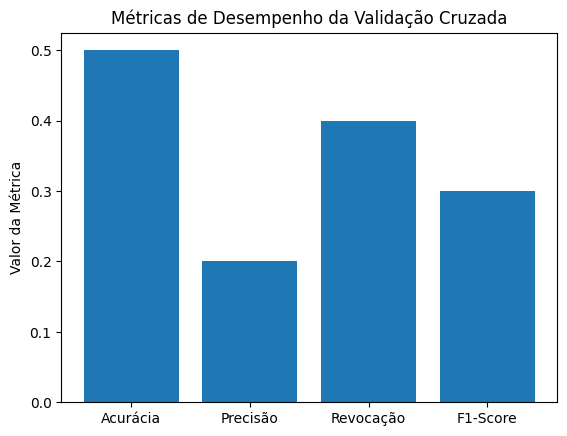

In [118]:
import matplotlib.pyplot as plt

def plot_metricas(acuracia_media, precisao_media, revocacao_media, f1_score_media):
    """Plota um gráfico de barras com as métricas de desempenho.

    Args:
        acuracia_media: Acurácia média do modelo.
        precisao_media: Precisão média do modelo.
        revocacao_media: Revocação média do modelo.
        f1_score_media: F1-score média do modelo.

    Returns:
        O objeto do gráfico.
    """

    fig, ax = plt.subplots()
    labels = ['Acurácia', 'Precisão', 'Revocação', 'F1-Score']
    values = [acuracia_media, precisao_media, revocacao_media, f1_score_media]
    ax.bar(labels, values)
    ax.set_title('Métricas de Desempenho da Validação Cruzada')
    ax.set_ylabel('Valor da Métrica')
    return fig

# Após cada treinamento ou validação cruzada, atualize as métricas e plote o gráfico
acuracia_media = 0.5  # Valor de exemplo
precisao_media = 0.2  # Valor de exemplo
revocacao_media = 0.4  # Valor de exemplo
f1_score_media = 0.3  # Valor de exemplo

grafico = plot_metricas(acuracia_media, precisao_media, revocacao_media, f1_score_media)

plt.show() 

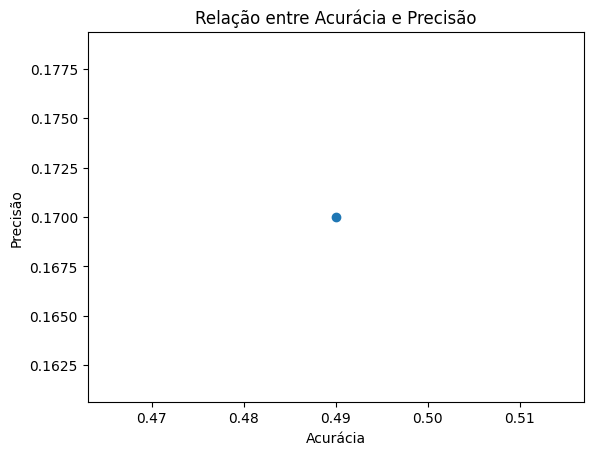

In [121]:
import matplotlib.pyplot as plt

# Resultados da validação cruzada (usando seus valores reais)
acuracia_media = 0.49
precisao_media = 0.17

# Cria um gráfico de dispersão
plt.scatter(acuracia_media, precisao_media)

# Define o título do gráfico
plt.title('Relação entre Acurácia e Precisão')

# Define o rótulo do eixo x
plt.xlabel('Acurácia')

# Define o rótulo do eixo y
plt.ylabel('Precisão')

# Exibe o gráfico
plt.show()

Estudo morfologico da Concentração e massa das galaxias

In [ ]:
# Plote dos subsamples
list_past_subid = []
list_future_subid = []
list_nonmerger_subid = []

cc_past_list = []
cc_future_list = []
cc_non_list = []

m20_past_list = []
m20_future_list = []
m20_non_list = []


for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_past_subid.append(subid_test[i])
        cc_past_list.append(cc_test[i])
        m20_past_list.append(m20_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_future_subid.append(subid_test[i])
        cc_future_list.append(cc_test[i])
        m20_future_list.append(m20_test[i])
    if y_sub_test[i,0]==0:
        list_nonmerger_subid.append(subid_test[i])
        cc_non_list.append(cc_test[i])
        m20_non_list.append(m20_test[i])

past_subid = np.stack(list_past_subid)
future_subid = np.stack(list_future_subid)
non_subid = np.stack(list_nonmerger_subid)

cc_past = np.stack(cc_past_list)
cc_future = np.stack(cc_future_list)
cc_non = np.stack(cc_non_list)

m20_past = np.stack(m20_past_list)
m20_future = np.stack(m20_future_list)
m20_non = np.stack(m20_non_list)

In [ ]:
#concentration histogram for the three subgroups (past, future and non-mergers)
bins = 40
plt.hist(cc_non, bins, alpha=0.9, label='cc: non-mergers')
plt.hist(cc_past, bins, alpha=0.6, label='cc: past mergers')
plt.hist(cc_future, bins, alpha=0.4, label='cc: future mergers', color='red')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#M20 histogram for the three subgroups (past, future and non-mergers)
bins = 40
plt.hist(m20_non, bins, alpha=0.9, label='m20: non-mergers')
plt.hist(m20_past, bins, alpha=0.6, label='m20: past mergers')
plt.hist(m20_future, bins, alpha=0.4, label='m20: future mergers', color='red')
plt.legend(loc='upper left')
plt.show()

Estudo da morfologia da massa estelar

In [ ]:
#subsamples for plotting
logM_past_list = []
logM_future_list = []
logM_non_list = []

for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        logM_past_list.append(logM_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        logM_future_list.append(logM_test[i])
    if y_sub_test[i,0]==0:
        logM_non_list.append(logM_test[i])

logM_past = np.stack(logM_past_list)
logM_future = np.stack(logM_future_list)
logM_non = np.stack(logM_non_list)

In [ ]:
#subsamples for plotting, but only TPs
prob_TP_list_past = []
prob_TP_list_future = []
logM_TP_list_past = []
logM_TP_list_future = []

In [ ]:
for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1 and prob[i] > 0.5 :
        prob_TP_list_past.append(prob[i])
        logM_TP_list_past.append(logM_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0 and prob[i] > 0.5:
        prob_TP_list_future.append(prob[i])
        logM_TP_list_future.append(logM_test[i])

logM_TP_past = np.stack(logM_TP_list_past)
prob_TP_past = np.stack(prob_TP_list_past)

logM_TP_future = np.stack(logM_TP_list_future)
prob_TP_future = np.stack(prob_TP_list_future)

In [ ]:
#subsamples for plotting, but only TNs
prob_TN_list = []
logM_TN_list = []

for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==0 and y_sub_test[i,1]==0 and prob[i] < 0.5 :
        prob_TN_list.append(prob[i])
        logM_TN_list.append(logM_test[i])
logM_TN = np.stack(logM_TN_list)
prob_TN = np.stack(prob_TN_list)

In [ ]:
#Plot 2D histogram of the distribution of all past mergers vs TP past mergers
sns.set_style("white")
plt.ylabel('CNN Output')
plt.xlabel('Stellar Mass')
plt.xlim(9.4, 11.8)
plt.xticks([9.5, 10, 10.5, 11, 11.5])
sns.kdeplot(logM_TP_past, prob_TP_past[:,0], cmap='RdGy', n_levels=10)
sns.kdeplot(logM_past, past[:,0], cmap= 'coolwarm', n_levels=10)

r = sns.color_palette("RdGy")[0]
b = sns.color_palette("coolwarm")[0]

red_patch = mpatches.Patch(color=r, label='TP past mergers')
blue_patch = mpatches.Patch(color=b, label='all past mergers')
plt.legend(handles=[red_patch,blue_patch],loc='lower right')
plt.show()

In [ ]:
#Plot 2D histogram of the distribution of all future mergers vs TP future mergers
sns.set_style("white")
plt.ylabel('CNN Output')
plt.xlabel('Stellar Mass')
plt.xlim(9.4, 11.8)
plt.xticks([9.5, 10, 10.5, 11, 11.5])
sns.kdeplot(logM_TP_future, prob_TP_future[:,0], cmap="RdGy",  n_levels=10)
sns.kdeplot(logM_future, future[:,0], cmap="coolwarm", n_levels=10)

r = sns.color_palette("RdGy")[0]
b = sns.color_palette("coolwarm")[0]

red_patch = mpatches.Patch(color=r, label='TP future mergers')
blue_patch = mpatches.Patch(color=b, label='all future mergers')
plt.legend(handles=[red_patch,blue_patch],loc='lower right')
plt.show(

In [ ]:
# Plot 2D histogram of the distribution of all non-mergers vs TN non-mergers
sns.set_style("white")
plt.ylabel('CNN Output')
plt.xlabel('Stellar Mass')
plt.xlim(9.4, 11.8)
plt.xticks([9.5, 10, 10.5, 11, 11.5])
sns.kdeplot(logM_non, non[:,0],n_levels=10, cmap="coolwarm")
sns.kdeplot(logM_TN, prob_TN[:,0],n_levels=10, cmap="RdGy")

r = sns.color_palette("RdGy")[0]
b = sns.color_palette("coolwarm")[0]

red_patch = mpatches.Patch(color=r, label='TN non-mergers')
blue_patch = mpatches.Patch(color=b, label='all non-mergers')
plt.legend(handles=[red_patch,blue_patch],loc='upper right')
plt.show()

Camadas de ativação

In [ ]:
# Extracts the outputs of all layers except the input layer
layer_outputs = [layer.output for layer in loaded_model.layers[1:]]
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs)

# returns the values of the layer activations in the original model
activations = activation_model.predict(x_test)

In [ ]:
# activation maps for all 8 filters in the first convolutional layer
fig1=plt.figure(figsize=(10,1.5))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    layer_activation = activations[0]
    plt.imshow(layer_activation[1649,i, :, :], cmap='viridis',aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
# activation maps for all 16 filters in the second convolutional layer
fig2=plt.figure(figsize=(10,3))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    layer_activation = activations[4]
    plt.imshow(layer_activation[1649,i, :, :], cmap='viridis',aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
# activation maps for all 32 filters in the third convolutional layer
fig3=plt.figure(figsize=(10,6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    layer_activation = activations[8]
    plt.imshow(layer_activation[1649,i, :, :], cmap='viridis',aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

Grad-CAM

In [ ]:
# largest output probabilities
example_i_TP=[]
example_i_FP=[]
example_i_TN=[]
example_i_FN=[]

for i in range(len(prob)):
    if prob[i] > 0.90 and y_test[i]==1:
        example_i_TP.append(i)
    if prob[i] > 0.80 and y_test[i]==0:
        example_i_FP.append(i)


for i in range(len(prob)):
    if prob[i] < 0.1 and y_test[i]==0:
        example_i_TN.append(i)
    if prob[i] < 0.15 and y_test[i]==1:
        example_i_FN.append(i)

In [ ]:
# lowest output probabilities
bad_example_i_TP=[]
bad_example_i_FP=[]
bad_example_i_TN=[]
bad_example_i_FN=[]

for i in range(len(prob)):
    if 0.5 < prob[i] < 0.55 and y_test[i]==1:
        bad_example_i_TP.append(i)
    if 0.5 < prob[i] < 0.58 and y_test[i]==0:
        bad_example_i_FP.append(i)


for i in range(len(prob)):
    if 0.44 < prob[i] < 0.5 and y_test[i]==0:
        bad_example_i_TN.append(i)
    if 0.44 < prob[i] < 0.5 and y_test[i]==1:
        bad_example_i_FN.append(i)

In [ ]:
#set channel_first data format in Keras backend in order for grad-CAM to work properly
K.set_image_data_format('channels_first')

# find the last convolutional layer
penultimate_layer = utils.find_layer_idx(loaded_model, 'conv2d_3')
class_idx = 0 # choose the class position in the output layer, here 0 since the output has just one dimention
layer_idx = -1 # location of the output layer

In [ ]:
# make a list of four TP, FP, TN and FN high-probability examples
example_list=[example_i_TP[22],example_i_TP[2],example_i_TP[4],example_i_TP[5],
             example_i_FP[1],example_i_FP[7],example_i_FP[3],example_i_FP[4],
             example_i_TN[2],example_i_TN[3],example_i_TN[11],example_i_TN[5],
             example_i_FN[1],example_i_FN[2],example_i_FN[15],example_i_FN[5]]

fig1=plt.figure(figsize=(7,7))
fig1.suptitle("TP, FP, TN and FN (from top to bottom rows) high-probability examples (grad-CAMs of the last convolutional layer)")

for i in range(16):
    grads = visualize_cam(loaded_model, layer_idx, filter_indices=0,
                              seed_input=x_test[example_list[i]], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier='guided')
    plt.subplot(4, 4, i + 1)
    plt.axis("off")

    plt.imshow(grads, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
# make a list of four TP, FP, TN and FN low-probability examples
bad_example_list=[bad_example_i_TP[22],bad_example_i_TP[2],bad_example_i_TP[4],bad_example_i_TP[5],
             bad_example_i_FP[1],bad_example_i_FP[7],bad_example_i_FP[3],bad_example_i_FP[4],
             bad_example_i_TN[13],bad_example_i_TN[20],bad_example_i_TN[11],bad_example_i_TN[5],
             bad_example_i_FN[1],bad_example_i_FN[7],bad_example_i_FN[15],bad_example_i_FN[5]]

fig1=plt.figure(figsize=(7,7))
fig1.suptitle("TP, FP, TN and FN (from top to bottom rows) low-probability examples (grad-CAMs of the last convolutional layer)")

for i in range(16):
    grads = visualize_cam(loaded_model, layer_idx, filter_indices=0,
                              seed_input=x_test[bad_example_list[i]], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier='guided')
    plt.subplot(4, 4, i + 1)
    plt.axis("off")

    plt.imshow(grads, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

Aplicação da técnica de Bootstraping

In [ ]:
# We make 1000 bootstraping resamples and recalculate AUC, accuracy etc.
# Then we find 95% CI for these values.

y_pred = pred # output class 0 or 1
y_prob = prob # output probability between 0 and 1
y_true = y_test # true class 0 or 1

n_bootstraps = 1000
rng_seed = 3  # controls reproducibility
bootstrapped_auc = []
bootstrapped_accuracy = []
bootstrapped_precision = []
bootstrapped_recall = []
bootstrapped_f1 = []
bootstrapped_brier = []
bootstrapped_fpr = []
bootstrapped_tpr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_prob) - 1, len(y_prob))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score_auc = roc_auc_score(y_true[indices], y_prob[indices])
    bootstrapped_auc.append(score_auc)

    score_acc = accuracy_score(y_true[indices], y_pred[indices])
    bootstrapped_accuracy.append(score_acc)

    score_precision = precision_score(y_true[indices], y_pred[indices])
    bootstrapped_precision.append(score_precision)

    score_recall = recall_score(y_true[indices], y_pred[indices])
    bootstrapped_recall.append(score_recall)

    score_f1 = f1_score(y_true[indices], y_pred[indices])
    bootstrapped_f1.append(score_f1)

    score_brier = brier_score_loss(y_true[indices], y_prob[indices])
    bootstrapped_brier.append(score_brier)

    fpr_score, tpr_score, thresholds_score = metrics.roc_curve(y_true[indices], y_prob[indices], pos_label=1)
    bootstrapped_fpr.append(fpr_score)
    bootstrapped_tpr.append(tpr_score)

In [ ]:
# we can plot histograms to see the bootstraped values
# change to "bootstrapped_accuracy,bootstrapped_precision,bootstrapped_recall,
# bootstrapped_f1,bootstrapped_brier", for other histograms
plt.hist(bootstrapped_auc, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [ ]:
sorted_auc = np.array(bootstrapped_auc)
sorted_acc = np.array(bootstrapped_accuracy)
sorted_precision = np.array(bootstrapped_precision)
sorted_recall = np.array(bootstrapped_recall)
sorted_f1 = np.array(bootstrapped_f1)
sorted_brier = np.array(bootstrapped_brier)

sorted_auc.sort()
sorted_acc.sort()
sorted_precision.sort()
sorted_recall.sort()
sorted_f1.sort()
sorted_brier.sort()

In [ ]:
# Computing the lower and upper bound of the 95% confidence interval
confidence_lower_auc = sorted_auc[int(0.025 * len(sorted_auc))]
confidence_upper_auc = sorted_auc[int(0.975 * len(sorted_auc))]

confidence_lower_acc = sorted_acc[int(0.025 * len(sorted_acc))]
confidence_upper_acc = sorted_acc[int(0.975 * len(sorted_acc))]

confidence_lower_precision = sorted_precision[int(0.025 * len(sorted_precision))]
confidence_upper_precision = sorted_precision[int(0.975 * len(sorted_precision))]

confidence_lower_recall = sorted_recall[int(0.025 * len(sorted_recall))]
confidence_upper_recall = sorted_recall[int(0.975 * len(sorted_recall))]

confidence_lower_f1 = sorted_f1[int(0.025 * len(sorted_f1))]
confidence_upper_f1 = sorted_f1[int(0.975 * len(sorted_f1))]

confidence_lower_brier = sorted_brier[int(0.025 * len(sorted_brier))]
confidence_upper_brier = sorted_brier[int(0.975 * len(sorted_brier))]


print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_prob)))
print("95% Confidence interval for the AUC score: [{:0.3} - {:0.3}]".format(
    confidence_lower_auc, confidence_upper_auc))
print("95%CI AUC errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_auc - roc_auc_score(y_true, y_prob),
    confidence_upper_auc - roc_auc_score(y_true, y_prob)))

print("Original Accuracy: {:0.3f}".format(accuracy_score(y_true, y_pred)))
print("95% Confidence interval for the Accuracy: [{:0.3} - {:0.3}]".format(
    confidence_lower_acc, confidence_upper_acc))
print("95%CI Accuracy errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_acc - accuracy_score(y_true, y_pred),
    confidence_upper_acc - accuracy_score(y_true, y_pred)))

print("Original Precision: {:0.3f}".format(precision_score(y_true, y_pred)))
print("95% Confidence interval for the Precision: [{:0.3} - {:0.3}]".format(
    confidence_lower_precision, confidence_upper_precision))
print("95%CI Precision errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_precision - precision_score(y_true, y_pred),
    confidence_upper_precision - precision_score(y_true, y_pred)))

print("Original Recall: {:0.3f}".format(recall_score(y_true, y_pred)))
print("95% Confidence interval for the Recall: [{:0.3} - {:0.3}]".format(
    confidence_lower_recall, confidence_upper_recall))
print("95%CI Recall errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_recall - recall_score(y_true, y_pred),
    confidence_upper_recall - recall_score(y_true, y_pred)))

print("Original F1 score: {:0.3f}".format(f1_score(y_true, y_pred)))
print("95% Confidence interval for the F1 score: [{:0.3} - {:0.3}]".format(
    confidence_lower_f1, confidence_upper_f1))
print("95%CI F1 score errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_f1 - f1_score(y_true, y_pred),
    confidence_upper_f1 - f1_score(y_true, y_pred)))

print("Original Brier score: {:0.3f}".format(brier_score_loss(y_true, y_prob)))
print("95% Confidence interval for the Brier score: [{:0.3} - {:0.3}]".format(
    confidence_lower_brier, confidence_upper_brier))
print("95%CI Brier score errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_brier - brier_score_loss(y_true, y_prob),
    confidence_upper_brier - brier_score_loss(y_true, y_prob)))

In [ ]:
# We can also find 95%CI (in vertical direction) for the ROC curve
tprs = []
base_fpr = np.linspace(0, 1, 1001)

for i in range(len(bootstrapped_fpr)):
    tpr1 = interp(base_fpr, bootstrapped_fpr[i], bootstrapped_tpr[i])
    tpr1[0] = 0.0
    tprs.append(tpr1)

tprs = np.array(tprs)
mean = tprs.mean(axis=0) # mean tpr
std = tprs.std(axis=0) # standard deviation of tpr

# 95%CI can be calculated as:
tprs_upper_95 = mean + 1.96*std  # 1.96 is z-score for 95%CI
tprs_lower_95 = mean - 1.96*std

# Plots ROC curve with 95%CI in the vertical direction
figsize=(6,6)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]

prist = plt.plot(fpr, tpr, 'navy', linewidth=2, label='pristine images')
prist_fill = plt.fill_between(base_fpr, tprs_lower_95, tprs_upper_95, color='deepskyblue', alpha=0.9, label='95%CI pristine images')
line = plt.plot(x_onetoone, y_onetoone, 'k--',linewidth=1, label="1-1")


plt.legend(loc='lower right')
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()